1. Import the required libraries

In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer




In [4]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score,confusion_matrix

2. Download the dataset

In [6]:
from google.colab import files 
uploaded =files.upload()

Saving spam.csv to spam.csv


3. Read The Dataset And Do Pre-Processing

In [7]:
df = pd.read_csv('spam.csv', encoding='latin-1')

df


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [8]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [11]:
df.shape

(5572, 2)

In [12]:
df.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [13]:
df.duplicated().sum()

403

In [14]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [15]:
df.isna().sum()

v1    0
v2    0
dtype: int64

In [9]:
df=df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])

In [16]:
df=df.rename(
{
    "v1":"Category",
    "v2":"Message"
},
    axis=1
)

In [39]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5169 non-null   object
 1   Message   5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [40]:
df["Message Length"]=df["Message"].apply(len)

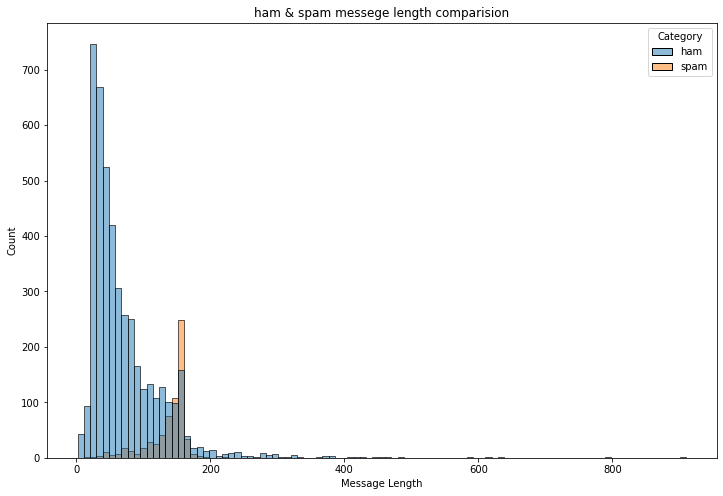

In [41]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [42]:
ham_desc=df[df["Category"]=="ham"]["Message Length"].describe()
spam_desc=df[df["Category"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

Ham Messege Length Description:
 count    4516.000000
mean       70.459256
std        56.358207
min         2.000000
25%        34.000000
50%        52.000000
75%        90.000000
max       910.000000
Name: Message Length, dtype: float64
************************************
Spam Message Length Description:
 count    653.000000
mean     137.891271
std       30.137753
min       13.000000
25%      132.000000
50%      149.000000
75%      157.000000
max      224.000000
Name: Message Length, dtype: float64


In [43]:
df.describe(include="all")

,Category,Message,Message Length
count,5169,5169,5169.000000
unique,2,5169,NaN
top,ham,"Go until jurong point, crazy.. Available only ...",NaN
freq,4516,1,NaN
mean,NaN,NaN,78.977945
std,NaN,NaN,58.236293
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,60.000000
75%,NaN,NaN,117.000000


In [ ]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

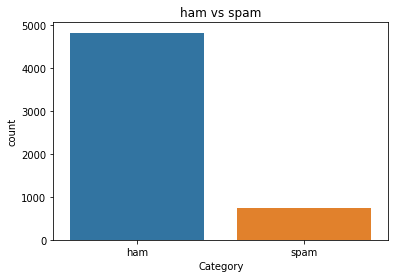

In [ ]:
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

In [ ]:
ham_count=df["Category"].value_counts()[0]
spam_count=df["Category"].value_counts()[1]

total_count=df.shape[0]

print("Ham contains:{:.2f}% of total df.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total df.".format(spam_count/total_count*100))

Ham contains:86.59% of total df.
Spam contains:13.41% of total df.


In [ ]:
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

In [ ]:
df.head()

,Category,Message,Message Length,Label
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0


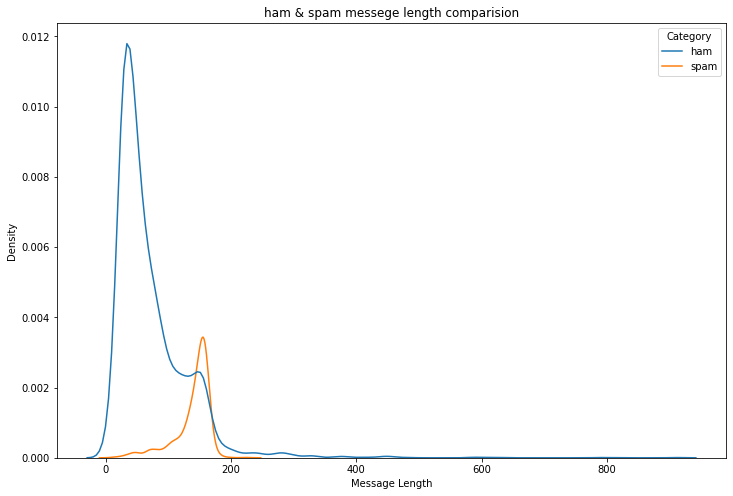

In [ ]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

4. Create The Model

In [45]:
model = Sequential()

5. Add Layers (LSTM, Dense-(Hidden Layers), Output)

In [46]:
model.add(Embedding(1000, output_dim=50, input_length=100))
model.add(LSTM(units=64 , return_sequences = True, dropout = 0.2))
model.add(LSTM(units=32 , dropout = 0.1))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 100, 64)           29440     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96,081
Trainable params: 96,081
Non-traina

6. Compile the Model

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

7.Fit the Model

In [ ]:
model.fit(X_train, y_train, batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=2)])

8.Save the model

In [55]:
model.save('spam-classifier.h5')

9.Test the model

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

In [59]:
from IPython.display import HTML
HTML('''
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);

To toggle on/off output_stderr, click here.''')